# Estimation of missing synapses per layer in simplified SSCx connectomes

- Computation of average dendritic synapse densities per layer (in #synapses/um)
- Based on a given reference density, estimation of missing numbers of synapses per layer, i.e., attributed to incoming connections from external regions that are outside this network model

ℹ️ Part of reproduction of simplified connectomes experiment described in [Pokorny et al. (2024)](https://doi.org/10.1101/2024.05.24.593860)

<u>Requirements</u>:
- Python venv with [Blue Brain SNAP](https://github.com/BlueBrain/snap) and [NeuroM](https://github.com/BlueBrain/NeuroM)
- [SSCx network model](https://doi.org/10.5281/zenodo.8026353) (=original circuit)
- Rewired (simplified) circuits, see `SSCx_rewiring.ipynb` (also available in Zenodo dataset)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bluepysnap import Circuit

## Run synapse count/density estimation

- Using SONATA lauch script [run_dendritic_synapse_density_SONATA.sh](https://bbpgitlab.epfl.ch/conn/structural/dendritic_synapse_density/-/blob/master/bin/run_dendritic_synapse_density_SONATA.sh)

In [17]:
def print_launch_command(circuit_config, nodes_popul_name, circuit_target, N_parallel, N_splits, save_file):
    print(f'sbatch run_dendritic_synapse_density_SONATA.sh {circuit_config} {nodes_popul_name} {circuit_target} {N_parallel} {N_splits} {save_file}')
    print()

In [3]:
circuit_target = 'hex0'
nodes_popul = 'S1nonbarrel_neurons'
N_parallel = 100  # Number of parallel jobs
N_splits = 100  # Number of data splits

ℹ️ Set paths to original and rewired circuit configs below

In [9]:
circuit_name_base = 'SSCx-HexO1-Release'

order_list = [1, 2, 3, 4, 5]
circuit_names = ['Orig'] + [f'Order-{_ord}' for _ord in order_list]
circuit_configs = ['/gpfs/bbp.cscs.ch/project/proj83/jira-tickets/NSETM-1948-extract-hex-O1/data/O1_data/circuit_config.json'] + \
                  [f'/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/circuits/{circuit_name_base}__ConnRewireOrder{_ord}Hex0EE/circuit_config.json' for _ord in order_list]

ℹ️ Set output path below

In [11]:
output_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/missing_synapses'
if not os.path.exists(output_path):
    os.makedirs(output_path)

ℹ️ Configure the SLURM script `run_dendritic_synapse_density_SONATA.sh` according to the used computation system and run below LAUNCH COMMANDS for running synapse density estimations

ℹ️ All missing synapse estimation results are also contained in the Zenodo dataset

In [18]:
for _nm, _cfg in zip(circuit_names, circuit_configs):
    print(f'### LAUNCH COMMAND "{_nm}" ###')
    save_file = os.path.join(output_path, f'{_nm}_cell_table_{nodes_popul}_{circuit_target}.h5')
    print_launch_command(_cfg, nodes_popul, circuit_target, N_parallel, N_splits, save_file)

### LAUNCH COMMAND "Orig" ###
sbatch run_dendritic_synapse_density_SONATA.sh /gpfs/bbp.cscs.ch/project/proj83/jira-tickets/NSETM-1948-extract-hex-O1/data/O1_data/circuit_config.json S1nonbarrel_neurons hex0 100 100 /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/missing_synapses/Orig_cell_table_S1nonbarrel_neurons_hex0.h5

### LAUNCH COMMAND "Order-1" ###
sbatch run_dendritic_synapse_density_SONATA.sh /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/circuits/SSCx-HexO1-Release__ConnRewireOrder1Hex0EE/circuit_config.json S1nonbarrel_neurons hex0 100 100 /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/missing_synapses/Order-1_cell_table_S1nonbarrel_neurons_hex0.h5

### LAUNCH COMMAND "Order-2" ###
sbatch run_dendritic_synapse_density_SONATA.sh /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokor

---
WAIT UNTIL ALL ESTIMATION RUNS HAVE SUCCESSFULLY COMPLETED

---

## Estimate and visualize missing synapses

- Missing EXC synapses per synapse class & layer
- Local connectivity
- Reference density of 1.1 # syn/um (Markram et al. 2015)

ℹ️ Set path below pointing to output table path and density estimation results

In [47]:
# Summary table will be stored here
tab_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/missing_synapses'

# Results files from estimation runs
tab_names = ['Orig'] + [f'Order-{_ord}' for _ord in order_list]
tab_files = ['Orig_cell_table_S1nonbarrel_neurons_hex0__20240205_104244.h5',
             'Order-1_cell_table_S1nonbarrel_neurons_hex0__20240205_104240.h5',
             'Order-2_cell_table_S1nonbarrel_neurons_hex0__20240205_104313.h5',
             'Order-3_cell_table_S1nonbarrel_neurons_hex0__20240205_104325.h5',
             'Order-4_cell_table_S1nonbarrel_neurons_hex0__20240205_104334.h5',
             'Order-5_cell_table_S1nonbarrel_neurons_hex0__20240205_104341.h5']

In [20]:
# Load tables
cell_tables = [pd.read_hdf(os.path.join(tab_path, _fn)) for _fn in tab_files]

# Check that differences only in E counts
for _idx in range(1, len(cell_tables)):
    assert cell_tables[0]['total_dendrite_length'].equals(cell_tables[_idx]['total_dendrite_length'])
    assert cell_tables[0]['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical__I_count'].equals(cell_tables[_idx]['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical__I_count'])
    assert not cell_tables[0]['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical__E_count'].equals(cell_tables[_idx]['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical__E_count'])

In [23]:
# Add total counts & densities
# [Here, one could sum counts from incoming VPM/POm projections, etc.
#  But we only consider local connectivity here.]
sum_columns = {'total_E_syn_count': ['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical__E_count'],
               'total_E_syn_density': ['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical__E_density'],
               'total_I_syn_count': ['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical__I_count'],
               'total_I_syn_density': ['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical__I_density']}
for _tab in cell_tables:
    for (k, v) in sum_columns.items():
        _tab.insert(column=k, value=np.sum(_tab[v], 1), loc=_tab.shape[1])

In [24]:
# Load base circuit
c = Circuit(circuit_configs[0])
nodes = c.nodes[nodes_popul]
nodes_table = nodes.get(circuit_target, properties=['synapse_class', 'layer', 'mtype'])

for _idx in range(len(cell_tables)):
    assert nodes_table.index.equals(cell_tables[_idx].index)

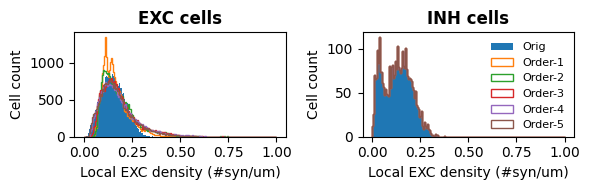

In [25]:
# Visualize histograms (local density only)
bins = np.linspace(0.0, 1.0, 201)
cell_classes = ['EXC', 'INH']
plt.figure(figsize=(6, 2))
for _cidx, _class in enumerate(cell_classes):
    plt.subplot(1, 2, _cidx + 1)
    cell_sel = nodes_table['synapse_class'] == _class
    for _tidx in range(len(cell_tables)):
        plt.hist(cell_tables[_tidx][cell_sel]['total_E_syn_density'], bins=bins, histtype='step' if _tidx else 'bar', label=tab_names[_tidx])
    plt.title(f'{_class} cells', fontweight='bold')
    # plt.gca().set_yscale('log')
    plt.xlabel('Local EXC density (#syn/um)')
    plt.ylabel('Cell count')
plt.legend(frameon=False, fontsize=8)
plt.tight_layout()
plt.show()

In [26]:
# Commpute missing synapses
ref_density = 1.1 # syn/um [Markram et al. 2015]

for _tab in cell_tables:
    _tab.insert(column='total_E_syn_density_missing', value=ref_density - _tab['total_E_syn_density'], loc=_tab.shape[1])
    _tab.insert(column='total_E_syn_count_missing', value=np.round(_tab['total_E_syn_density_missing'] * _tab['total_dendrite_length']).astype(int), loc=_tab.shape[1])

In [28]:
# Compute missing (local) EXC synapses per layer and store them as missing_counts.h5 file
lay_groups = {'L1': [1], 'L23': [2, 3], 'L4': [4], 'L5': [5], 'L6': [6]}
missing_counts_mean = []
missing_counts_std = []
for _tab in cell_tables:
    mcounts_mean = {}
    mcounts_std = {}
    for _class in ['EXC', 'INH']:
        for _k, _v in lay_groups.items():
            cell_sel = np.logical_and(nodes_table['synapse_class'] == _class, np.isin(nodes_table['layer'], _v))
            mcounts = _tab[cell_sel]['total_E_syn_count_missing']
            mcounts_mean[_k + _class[0]] = np.mean(mcounts)
            mcounts_std[_k + _class[0]] = np.std(mcounts)
    missing_counts_mean.append(mcounts_mean)
    missing_counts_std.append(mcounts_std)

df_missing_counts_mean = pd.DataFrame(missing_counts_mean, index=tab_names)
df_missing_counts_std = pd.DataFrame(missing_counts_std, index=tab_names)
df_file = os.path.join(tab_path, 'missing_counts.h5')
df_missing_counts_mean.to_hdf(df_file, 'missing_counts_mean')
df_missing_counts_std.to_hdf(df_file, 'missing_counts_std')

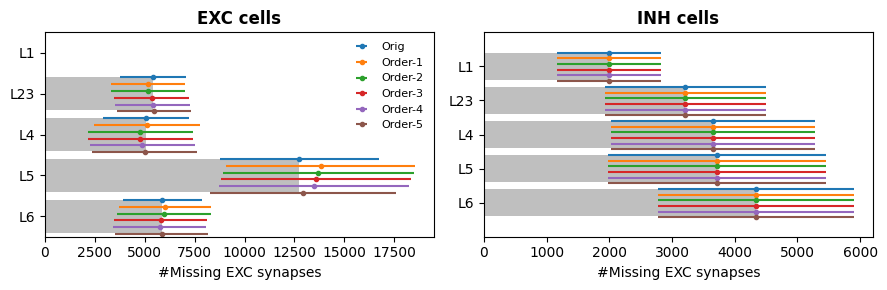

In [29]:
# Visualization of missing synapses
layers = list(lay_groups.keys())

fig = plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
for midx, mname in enumerate(tab_names):
    syn_count_E_mean = df_missing_counts_mean.loc[mname, [_k + 'E' for _k in layers]]
    syn_count_E_std = df_missing_counts_std.loc[mname, [_k + 'E' for _k in layers]]
    if midx == 0:
        plt.barh(layers, syn_count_E_mean, color='k', alpha=0.25)
    plt.errorbar(syn_count_E_mean, np.arange(len(syn_count_E_mean)) + midx / len(tab_names) - 0.4, xerr=syn_count_E_std, fmt='.', label=mname)
plt.title('EXC cells', fontweight='bold')
plt.xlabel('#Missing EXC synapses')
plt.ylim((-0.5, len(layers) - 0.5))
plt.gca().invert_yaxis()
plt.legend(frameon=False, fontsize=8, loc='upper right')

plt.subplot(1, 2, 2)
for midx, mname in enumerate(tab_names):
    syn_count_I_mean = df_missing_counts_mean.loc[mname, [_k + 'I' for _k in layers]]
    syn_count_I_std = df_missing_counts_std.loc[mname, [_k + 'I' for _k in layers]]
    if midx == 0:
        plt.barh(layers, syn_count_I_mean, color='k', alpha=0.25)
    plt.errorbar(syn_count_I_mean, np.arange(len(syn_count_I_mean)) + midx / len(tab_names) - 0.4, xerr=syn_count_I_std, fmt='.', label=mname)
plt.title('INH cells', fontweight='bold')
plt.xlabel('#Missing EXC synapses')
plt.ylim((-1, len(layers)))
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()